In [1]:
import time
import math
import copy
import torch
import pickle
import random
import logging
import warnings
import datetime
import pandas as pd
import numpy as np
from copy import deepcopy
import torch.nn as nn
import torch.optim as opt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from imblearn.under_sampling import RandomUnderSampler
import fairlearn.datasets
from tqdm import tqdm
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from torch.autograd import grad
from torch.autograd.functional import vhp
from torch.utils.data import Subset, DataLoader
from sklearn.metrics import mean_absolute_error, log_loss, r2_score, accuracy_score, precision_score, recall_score, precision_recall_fscore_support, classification_report
from scipy.stats import spearmanr
from folktables import ACSDataSource, ACSIncome, ACSPublicCoverage

import scienceplots
warnings.filterwarnings("ignore")

E = math.e

In [2]:
ds = ACSDataSource(survey_year='2018', horizon='5-Year', survey='person')
STATE_DATA = ds.get_data(states=["AR"], download=True)

### Utility Functions

In [3]:
from matplotlib.ticker import FormatStrFormatter

In [4]:
def visualize_result(e_k_actual, e_k_estimated, ep, k_):
    plt.rcParams['figure.dpi'] = 300
    plt.style.use(['science'])
#     plt.rcParams.update({'font.size': 5})
    colors = cm.cool(np.linspace(0, 1, len(e_k_estimated)))
#     e_k_estimated = [-1*ek for ek in e_k_estimated]
    fig, ax = plt.subplots()
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    
    min_x = np.min(e_k_actual)
    max_x = np.max(e_k_actual)
    min_y = np.min(e_k_estimated)
    max_y = np.max(e_k_estimated)
    
# #     plt.rcParams['figure.figsize'] = 15, 15
    z = np.polyfit(e_k_actual,  e_k_estimated, 1)
    p = np.poly1d(z)
    xx = np.linspace(-p(2)/p(1), max(e_k_actual)+.0001)
    yy = np.polyval(p, xx)
    #add trendline to plot
    ax.plot(xx, yy, ls="-", color='k')
    
    for k in range(len(e_k_actual)):
        ax.scatter(e_k_actual[k], e_k_estimated[k], zorder=2, s=15, color=colors[k])

    ax.set_title(f'Actual vs. Estimated loss for k={k_:.2f}%', fontsize=8)
    ax.set_xlabel('Actual loss difference', fontsize=8)
    ax.set_ylabel('Estimated loss difference', fontsize=8)
   
    ax.set_xlim(min_x-.0001, max_x+.0001)
    ax.set_ylim(min_y-.0001, max_y+.0001)
    
#     #label_locations = np.arange(5)  
#     #width = 0.25 
    
#     xlabels = np.linspace(min_x-.0001, max_x+.0001, 6)
#     ylabels = np.linspace(min_y-.0001, max_y+.0001, 6)
    
    text = 'MAE = {:.03}\nP = {:.03}'.format(mean_absolute_error(e_k_actual, e_k_estimated), spearmanr(e_k_actual, e_k_estimated).correlation)
    ax.text(max_x+.00001,min_y-.00008, text, verticalalignment='bottom', horizontalalignment='right', fontsize=8)
# #     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# #     plt.tight_layout()
    plt.xticks(rotation = 45, fontsize=7, visible=True)
    plt.yticks(fontsize=7)
 
    plt.show()
    # cooler color = smaller epsilon

In [5]:
 class CreateData(torch.utils.data.Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = self.targets[idx]

        return out_data, out_label

In [6]:
def get_data_group(dfTrain, feature_set, label, k):    

    selected_group = dfTrain.loc[dfTrain['SEX'] == 0]

    num_to_sample = int((k/100)*len(dfTrain))

    sampled_group = selected_group.sample(n=num_to_sample, ignore_index=False)
    not_selected = dfTrain.drop(sampled_group.index)

    selected_group_X = sampled_group[feature_set]
    selected_group_y = sampled_group[label]

    not_selected_group_X = not_selected[feature_set]
    not_selected_group_y = not_selected[label]   
    
    return selected_group_X, selected_group_y, not_selected_group_X, not_selected_group_y


In [7]:
def get_acspubcov(data):
    features, labels, _ = ACSPublicCoverage.df_to_pandas(data)
    
    df = pd.concat([features, labels], axis=1)
    
    df = df.drop_duplicates(keep='first', ignore_index=True)
    df = df.drop(['ANC', 'ST', 'SCHL', 'ESP', 'FER', 'MIG', 'DEAR', 'DEYE', 'DREM'], axis=1)
    
    column_names = ['AGEP', 'MAR', 'SEX', 'DIS', 'CIT', 'PINCP', 'ESR', 'RAC1P', 'MIL', 'NATIVITY']
    
    def numericalBinary(dataset, features):
        dataset[features] = np.where(dataset[features] >= dataset[features].mean(), 1, 0)

    def binarize(dataset, features):
        dataset[features] = np.where(df[features] == 1, 1, 0)
            
    numericalBinary(df,['AGEP', 'PINCP'])
    binarize(df, ['MAR', 'SEX', 'DIS', 'RAC1P', 'PUBCOV', 'NATIVITY'])
    
    #df['ESP'] = np.where((df['ESP'] == 1) | (df['ESP'] == 2) | (df['ESP'] == 3) | (df['ESP'] == 4), 1, 0)
    df['CIT'] = np.where((df['CIT'] == 1) | (df['CIT'] == 3), 1, 0)
    df['MIL'] = np.where((df['MIL'] == 1) | (df['MIL'] == 2) | (df['MIL'] == 3), 1, 0)
    df['ESR'] = np.where((df['ESR'] == 1) | (df['ESR'] == 2) | (df['ESR'] == 4) | (df['ESR'] == 5), 1, 0)
    
#     to_replace = ['workclass', 'education-num', 'marital-status', 'occupation','relationship', 'native-country']
#     dfTrain = pd.get_dummies(dfTrain, columns=to_replace, drop_first = False)
    
    num_train = int(len(df) * .8)
    dfTrain = df.sample(n=num_train, replace=False, axis=0, ignore_index=False)

    dfTest = df.drop(dfTrain.index, axis=0)
    
    label = 'PUBCOV'
    return dfTrain, dfTest, label

In [8]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

### Randomized Response

In [9]:
def get_p(epsilon):
    p = float(E ** epsilon) / float(1 + (E ** epsilon))
    q = 1-p
    
    return p, q

### Models

In [10]:
class LogReg(torch.nn.Module):
    def __init__(self, num_features, scikit_model):
        super(LogReg, self).__init__()
        
        self.fc1 = torch.nn.Linear(num_features, 1, bias=False)
        self.criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
        
        weights = torch.from_numpy(scikit_model.coef_).type(torch.float32)
        biases = torch.from_numpy(np.array(scikit_model.intercept_)).type(torch.float32)

        with torch.no_grad():
            self.fc1.weight = nn.Parameter(weights)
            self.fc1.bias = nn.Parameter(biases)

    def forward(self, x):
        logits = self.fc1(x)

        return logits

### Influence Calculation Functions


In [11]:
def calc_influence_single(scikit_model, epsilon, train_data, test_data, group_data, device, num_features, criterion):
        
    torch_model = LogReg(num_features, scikit_model)
    torch_model.to(device)
    
    start = time.time()
    est_hess = explicit_hess(torch_model, train_data, device, criterion)
    
    grad_test = grad_z([test_data[0], test_data[1]], torch_model, device, criterion)
 
    s_test_vec = torch.mm(grad_test[0], est_hess.to(device))

    p, q = get_p(epsilon) 
    
    p_01, p_10 = q, q
    
    S_pert = 1 - group_data[1]
    
    y_w_group_pert = pd.concat([group_data[3], S_pert], axis = 0, ignore_index=True)
    y_wo_pert = pd.concat([group_data[3], group_data[1]], axis = 0, ignore_index=True)
    reconstructed_x = pd.concat([group_data[2], group_data[0]], axis = 0, ignore_index=True)
  
    assert len(S_pert) == len(group_data[1])
    grad_z_vec = grad_training([group_data[0], group_data[1]], S_pert, torch_model, device, epsilon)
   
    influence = torch.dot(s_test_vec.flatten(), grad_z_vec[0].flatten()) * (1/len(reconstructed_x))
    end = time.time() - start
    
    return influence.cpu().detach().numpy(), end

In [12]:
def explicit_hess(model, train_data, device, criterion):

    logits = model(train_data[0])
    loss = criterion(logits.ravel(), train_data[1]) #reduction mean

    grads = grad(loss, model.parameters(), retain_graph=True, create_graph=True)

    hess_params = torch.zeros(len(model.fc1.weight[0]), len(model.fc1.weight[0]))
    
    for i in range(len(model.fc1.weight[0])):
        hess_params_ = grad(grads[0][0][i], model.parameters(), retain_graph=True)[0][0]
        for j, hp in enumerate(hess_params_):
            hess_params[i,j] = hp

    inv_hess = torch.linalg.inv(hess_params)
    return inv_hess

In [13]:
def grad_z(test_data, model, device, criterion):

    model.eval()

    logits = model(test_data[0])
    loss = criterion(logits.ravel(), test_data[1]) # reduction mean
    
    return grad(loss, model.parameters())

In [14]:
def grad_training(train_data, y_perts, model, device, epsilon):
    
    criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
    
    train_data_features = torch.FloatTensor(train_data[0].values).to(device)
    train_data_labels = torch.FloatTensor(train_data[1].values).to(device)
    train_pert_data_labels = torch.FloatTensor(y_perts.values).to(device)
    
    model.eval()

    logits = model(train_data_features)

    orig_loss = criterion(logits.ravel(), train_data_labels)
    pert_loss = criterion(logits.ravel(), train_pert_data_labels)
    loss = float(1/(1 + (E ** epsilon)))*(pert_loss - orig_loss)
    
    to_return = grad(loss, model.parameters())
    
        
    return to_return

### Main Function

In [15]:
def Main(dataset, epsilons, ks, num_rounds):

    device = 'cuda:3' if torch.cuda.is_available() else 'cpu'
    criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
    
    all_orig_loss_e_k = []
    all_est_loss_e_k = []
    all_time = []
    
    for nr in range(num_rounds):
        print(f'\nRound {nr+1}')
        ############
        # Get data #
        ############
        print('\nGetting Data...')
        
        dfTrain, dfTest, label = get_acspubcov(STATE_DATA)

        feature_set = list(set(dfTrain.columns) - {label})
        num_features = len(feature_set)

        X_train, X_test = dfTrain[feature_set].values, dfTest[feature_set].values
        y_train, y_test = dfTrain[label].values, dfTest[label].values
#        
#         new_train_df = pd.concat([X_train, y_train], axis=1)
  
#         train_sample_num = len(X_train)
    
        x_test_input = torch.FloatTensor(X_test).to(device)
        y_test_input = torch.FloatTensor(y_test).to(device)

        x_train_input = torch.FloatTensor(X_train).to(device)
        y_train_input = torch.FloatTensor(y_train).to(device)
   
        ##############################################
        # Train original model and get original loss #
        ##############################################
        print('Training original model...')
        LR = SGDClassifier(loss='log_loss', penalty='None', eta0=0.01, fit_intercept=False, learning_rate='constant')
        LR.fit(X_train, y_train)
        
        model_to_send = deepcopy(LR)
        
        predictions = LR.predict_proba(X_test)
        label_predictions = [np.argmax(p) for p in predictions]
      
        acc_ori = accuracy_score(y_test, label_predictions)
        test_loss_ori = log_loss(y_test, predictions, eps=1e-15, labels=[0,1])
        
        e_k_act_losses = []
        e_k_est_losses = []
        influence_time = []
        
        ################################################################
        # Perform influence and retraining for all epsilons a k values #
        ################################################################
        print('\nBegining epsilon and k rounds')
        print('-----------------------------')
        for ep in epsilons:
            print(f'\nEpsilon: {ep}')
            
            k_act_losses = []
            k_est_losses = []
            inf_time = []
            
            for k in ks:
                # Influence
                print(f'k: {k:.2f}')
                selected_group_X, selected_group_y, not_selected_group_X, not_selected_group_y = get_data_group(dfTrain, feature_set, label, k)
                loss_diff_approx, tot_time = calc_influence_single(model_to_send, ep, [x_train_input, y_train_input], [x_test_input, y_test_input], [selected_group_X, selected_group_y, not_selected_group_X, not_selected_group_y], device, num_features, criterion)
                print(f'Approx difference: {loss_diff_approx:.5f}')
              
                ###########
                # Retrain #
                ###########
                
                p, q = get_p(ep)
                
                pert_selected_group_y = []
                
                for i, elem in enumerate(selected_group_y.values):
                    rnd = np.random.random()
                    if rnd <= p:
                        pert_selected_group_y.append(elem)
                    else:
                        pert_selected_group_y.append(1 - elem)

                y_w_group_pert = pd.concat([not_selected_group_y, pd.DataFrame(pert_selected_group_y)], axis = 0, ignore_index=True)
                y_wo_pert = pd.concat([not_selected_group_y, selected_group_y], axis = 0, ignore_index=True)
                reconstructed_x = pd.concat([not_selected_group_X, selected_group_X], axis = 0, ignore_index=True)
                
                pert_LR = SGDClassifier(loss='log_loss', penalty='None', eta0=0.01, fit_intercept=False, learning_rate='constant')
                pert_LR.fit(reconstructed_x, y_w_group_pert)
                pert_param = LR.coef_

                pert_predictions = pert_LR.predict_proba(X_test)
                pert_label_predictions = [np.argmax(p) for p in pert_predictions]

                acc_pert = accuracy_score(y_test, pert_label_predictions)
                test_loss_retrain = log_loss(y_test, pert_predictions, eps=1e-15, labels=[0,1])
                
#                 model_pert = LogisticRegression(num_features)
#                 model_pert.load_state_dict(torch.load('initial_config.pth'))
#                 model_pert.to(device)
#                 model_pert = train(model_pert, [torch.FloatTensor(reconstructed_x.values).to(device), torch.FloatTensor(y_w_group_pert.values).to(device)])
#                 test_loss_retrain, acc_retrain = model_pert.loss(model_pert(x_test_input), y_test_input, False)

                 # get true loss diff
                loss_diff_true = test_loss_retrain - test_loss_ori
                print(f'True difference: {loss_diff_true:.5f}')
                k_act_losses.append(loss_diff_true)
                k_est_losses.append(loss_diff_approx)
                inf_time.append(tot_time)
            
            e_k_act_losses.append(k_act_losses)
            e_k_est_losses.append(k_est_losses)
            influence_time.append(inf_time)
            
        all_orig_loss_e_k.append(e_k_act_losses)
        all_est_loss_e_k.append(e_k_est_losses) 
        all_time.append(influence_time)
    
    return all_orig_loss_e_k, all_est_loss_e_k, all_time

### Perform Experiment 

#### Constants

In [16]:
epsilons = np.linspace(.001, 5, 30) #30
k = np.linspace(26.78, 26.78, 1) #10
rounds = 10

In [17]:
all_orig_loss_e_k, all_est_loss_e_k, all_time = Main('adult', epsilons, k, rounds)

with open('all_orig_loss_e_k_adult_full_k.txt', "wb") as file:   #Pickling
    pickle.dump(all_orig_loss_e_k, file)

with open('all_est_loss_e_k_adult_full_k.txt', "wb") as file2:   #Pickling
    pickle.dump(all_est_loss_e_k, file2)


Round 1

Getting Data...
Training original model...

Begining epsilon and k rounds
-----------------------------

Epsilon: 0.001
k: 26.78
Approx difference: -0.00066
True difference: 0.01271

Epsilon: 0.17337931034482756
k: 26.78
Approx difference: -0.00047
True difference: 0.01544

Epsilon: 0.3457586206896551
k: 26.78
Approx difference: -0.00059
True difference: 0.00621

Epsilon: 0.5181379310344827
k: 26.78
Approx difference: -0.00052
True difference: 0.00608

Epsilon: 0.6905172413793103
k: 26.78
Approx difference: -0.00041
True difference: 0.01416

Epsilon: 0.8628965517241378
k: 26.78
Approx difference: -0.00037
True difference: 0.00790

Epsilon: 1.0352758620689653
k: 26.78
Approx difference: -0.00030
True difference: 0.00226

Epsilon: 1.207655172413793
k: 26.78
Approx difference: -0.00022
True difference: 0.00625

Epsilon: 1.3800344827586204
k: 26.78
Approx difference: -0.00024
True difference: 0.00259

Epsilon: 1.5524137931034478
k: 26.78
Approx difference: -0.00024
True differenc

True difference: -0.00079

Epsilon: 5.0
k: 26.78
Approx difference: 0.00009
True difference: 0.00397

Round 4

Getting Data...
Training original model...

Begining epsilon and k rounds
-----------------------------

Epsilon: 0.001
k: 26.78
Approx difference: -0.00132
True difference: 0.01185

Epsilon: 0.17337931034482756
k: 26.78
Approx difference: -0.00142
True difference: 0.01824

Epsilon: 0.3457586206896551
k: 26.78
Approx difference: -0.00124
True difference: 0.01010

Epsilon: 0.5181379310344827
k: 26.78
Approx difference: -0.00105
True difference: 0.00291

Epsilon: 0.6905172413793103
k: 26.78
Approx difference: -0.00102
True difference: 0.00381

Epsilon: 0.8628965517241378
k: 26.78
Approx difference: -0.00079
True difference: 0.00435

Epsilon: 1.0352758620689653
k: 26.78
Approx difference: -0.00078
True difference: 0.00043

Epsilon: 1.207655172413793
k: 26.78
Approx difference: -0.00053
True difference: -0.00044

Epsilon: 1.3800344827586204
k: 26.78
Approx difference: -0.00057
Tru

True difference: 0.00221

Epsilon: 4.655241379310344
k: 26.78
Approx difference: 0.00003
True difference: -0.00004

Epsilon: 4.8276206896551725
k: 26.78
Approx difference: 0.00003
True difference: 0.00061

Epsilon: 5.0
k: 26.78
Approx difference: 0.00002
True difference: 0.00010

Round 7

Getting Data...
Training original model...

Begining epsilon and k rounds
-----------------------------

Epsilon: 0.001
k: 26.78
Approx difference: -0.00117
True difference: 0.01934

Epsilon: 0.17337931034482756
k: 26.78
Approx difference: -0.00113
True difference: 0.01311

Epsilon: 0.3457586206896551
k: 26.78
Approx difference: -0.00098
True difference: 0.01680

Epsilon: 0.5181379310344827
k: 26.78
Approx difference: -0.00091
True difference: 0.00861

Epsilon: 0.6905172413793103
k: 26.78
Approx difference: -0.00086
True difference: 0.01414

Epsilon: 0.8628965517241378
k: 26.78
Approx difference: -0.00083
True difference: 0.01472

Epsilon: 1.0352758620689653
k: 26.78
Approx difference: -0.00068
True d

True difference: 0.00099

Epsilon: 4.310482758620689
k: 26.78
Approx difference: -0.00004
True difference: 0.00024

Epsilon: 4.482862068965517
k: 26.78
Approx difference: -0.00003
True difference: 0.00089

Epsilon: 4.655241379310344
k: 26.78
Approx difference: -0.00003
True difference: 0.00032

Epsilon: 4.8276206896551725
k: 26.78
Approx difference: -0.00002
True difference: 0.00883

Epsilon: 5.0
k: 26.78
Approx difference: -0.00002
True difference: 0.00091

Round 10

Getting Data...
Training original model...

Begining epsilon and k rounds
-----------------------------

Epsilon: 0.001
k: 26.78
Approx difference: 0.00443
True difference: 0.01749

Epsilon: 0.17337931034482756
k: 26.78
Approx difference: 0.00415
True difference: 0.01080

Epsilon: 0.3457586206896551
k: 26.78
Approx difference: 0.00381
True difference: 0.01266

Epsilon: 0.5181379310344827
k: 26.78
Approx difference: 0.00344
True difference: 0.01842

Epsilon: 0.6905172413793103
k: 26.78
Approx difference: 0.00317
True diffe

In [18]:
with open('all_orig_loss_e_k_adult_full_k.txt', 'rb') as f:
    all_orig_loss_e_k = pickle.load(f)
    
with open('all_est_loss_e_k_adult_full_k.txt', 'rb') as f:
    all_est_loss_e_k = pickle.load(f)

In [19]:
print(len(all_orig_loss_e_k[0]))

30


In [20]:
# [actual, estimate]

sum_orig_loss_e_k = [[0 for _ in range(len(k))] for _ in range(len(epsilons))]
sum_est_loss_e_k = [[0 for _ in range(len(k))] for _ in range(len(epsilons))]
sum_time = [[0 for _ in range(len(k))] for _ in range(len(epsilons))]

avg_orig_loss = []
avg_est_loss = []
avg_time = []

for round_ in range(len(all_orig_loss_e_k)):
    for e in range(len(epsilons)):
        for k_ in range(len(k)):
            sum_orig_loss_e_k[e][k_] = sum_orig_loss_e_k[e][k_] + all_orig_loss_e_k[round_][e][k_]
            sum_est_loss_e_k[e][k_] = sum_est_loss_e_k[e][k_] + all_est_loss_e_k[round_][e][k_]
            

for e in range(len(epsilons)):
    avg_orig_loss.append([ elem / len(all_orig_loss_e_k) for elem in sum_orig_loss_e_k[e]])
    avg_est_loss.append([elem/ len(all_orig_loss_e_k) for elem in sum_est_loss_e_k[e]])

k_e_orig = [[] for _ in range(len(k))]
k_e_est = [[] for _ in range(len(k))]

for e in range(len(epsilons)):
    for k_ in range(len(k)):
        k_e_orig[k_].append(avg_orig_loss[e][k_])
        k_e_est[k_].append(avg_est_loss[e][k_])


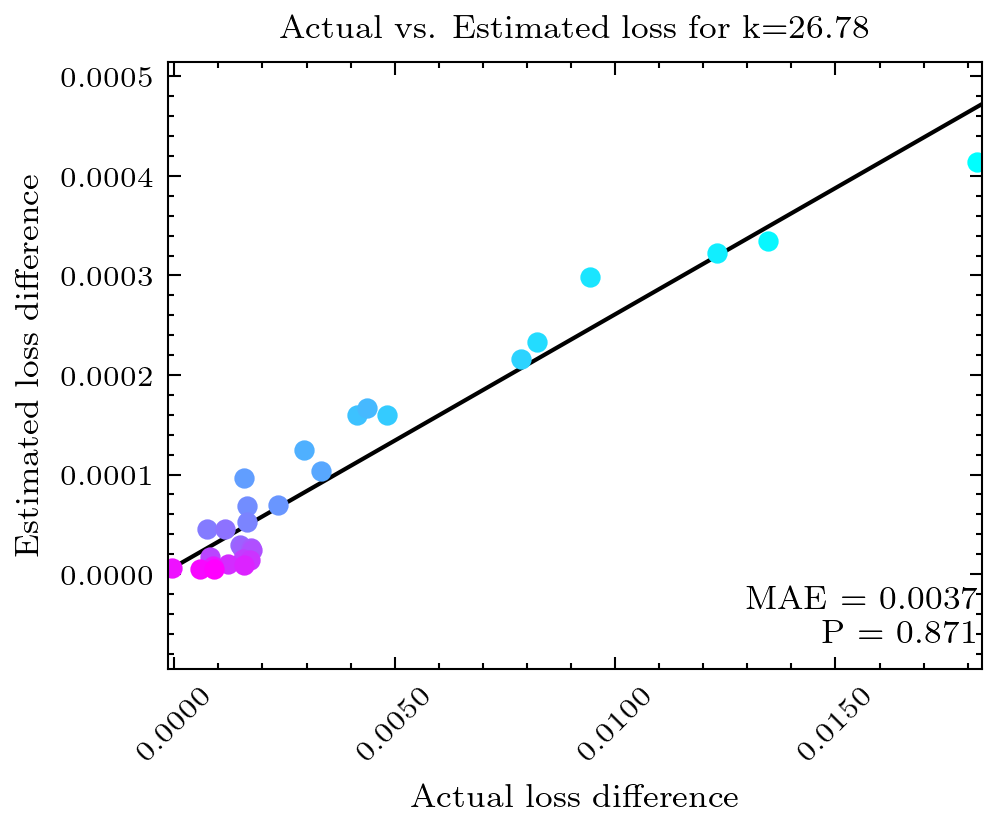

In [21]:
for i in range(len(k_e_orig)):
    visualize_result(k_e_orig[i], k_e_est[i], epsilons, k[i])